In [1]:
import pandas as pd
import os
import glob
import json
import codecs
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import datefinder
import datetime
import swifter
import numpy as np

# Appeals Cases

In [2]:
## get all courts 
court_jsons = []
for x in glob.glob('../court_documents/all-courts/*.json'):
    jsn_str = codecs.open(x, encoding='utf-8').read()
    court_json = json.loads(jsn_str)
    court_jsons.append(court_json)

court_df = pd.DataFrame(court_jsons).loc[lambda df: df['full_name'].notnull()]

## get just appeals courts
appeals_courts = (court_df
 .loc[lambda df: df['short_name'].str.contains('Appeals')]
)

## get processed appeals courts
court_opinions = pd.Series(glob.glob("../court_documents/opinions/*"))
## .csv files
csv_files = (
    court_opinions.loc[lambda s: s.str.endswith('.csv')]
        .to_frame('csv')
        .assign(name=lambda df: df['csv'].apply(os.path.basename).str.replace('.csv', ''))
        .set_index('name')
)

appeals = (csv_files
           .reindex(appeals_courts['id'])
           .loc[lambda df: df['csv'].notnull()]
           .assign(size=lambda df: df['csv'].apply(os.path.getsize))
          )

In [24]:
appeals.merge(
    pd.Series(opinion_dfs).apply(lambda x: x.shape[0]).to_frame('num_rows'),
    left_index=True,
    right_index=True
).assign(ratio=lambda df: (df['size']/df['num_rows']).round(0)).sort_values('size', ascending=False).head()

,csv,size,num_rows,ratio
arkctapp,../court_documents/opinions\arkctapp.csv,173154937,5410,32006.0
utahctapp,../court_documents/opinions\utahctapp.csv,167008887,3454,48352.0
scctapp,../court_documents/opinions\scctapp.csv,157078643,3861,40683.0
massappct,../court_documents/opinions\massappct.csv,151820779,3639,41720.0
oklacivapp,../court_documents/opinions\oklacivapp.csv,142552510,3222,44243.0


In [30]:
# csv_files.assign(size=lambda df: df['csv'].apply(os.path.getsize))

In [28]:
def get_text(row):
    if pd.notnull(row['plain_text']) and row['plain_text'] != '':
        return row['plain_text']
    if pd.notnull(row['html_columbia']):
        return BeautifulSoup(row['html_columbia']).get_text()
    if pd.notnull(row['html_lawbox']):
        return BeautifulSoup(row['html_lawbox']).get_text()
    return ''

def get_dates(text):
    try:
        date_list = list(datefinder.find_dates(text[:100]))
        date_list = list(filter(lambda x: x < datetime.datetime(2018, 1, 1), date_list))
        date_list = list(filter(lambda x: x > datetime.datetime(1980, 1, 1), date_list))
        return date_list[0]
    except:
        return

In [43]:
opinion_dfs = []
for idx, appeals_file, size in tqdm(appeals.sort_values('size').iloc[2:].itertuples(), total=len(appeals)):
    fn = os.path.basename(appeals_file).replace('.csv', '')
    
    opinion_chunks = pd.read_csv(appeals_file, chunksize=1000)
    for df in opinion_chunks:
        plain_text = df.apply(get_text, axis=1).to_frame('plain_text')
        plain_text['date'] = plain_text['plain_text'].apply(get_dates)
        plain_text['file'] = fn 
        plain_text = plain_text.loc[lambda df: df['date'] > datetime.datetime(2008, 1, 1)]
        opinion_dfs.append(plain_text)

C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname CST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname CDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname M identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:12

In [65]:
opinion_df_all = pd.concat(opinion_dfs)

In [67]:
opinion_df_all.to_csv("../court_documents/unprocessed_appeals_plain_text__current.csv")

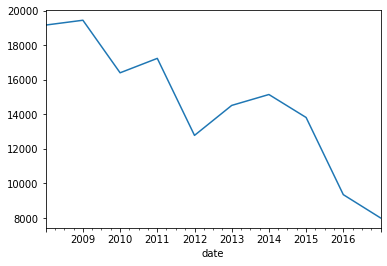

In [76]:
opinion_df_all.assign(c=1).groupby(pd.Grouper(key='date', freq='365D'))['c'].sum().plot()

# Modeling

In [71]:
t.shape

(8715,)

In [50]:
opinion_df_all.shape

(145783, 4)

In [46]:
t.str.contains('SUMMARY DISPOSITION ORDER').value_counts()

False    12587
True         6
Name: plain_text, dtype: int64

In [50]:
t.str.contains('FACT').value_counts()

False    12373
True       220
Name: plain_text, dtype: int64

In [64]:
t.str.lower().str.contains('background').value_counts()

False    6912
True     1788
Name: plain_text, dtype: int64

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

court_cv = CountVectorizer(min_df=.005, max_df=.4, ngram_range=(2, 2))
lr = LogisticRegressionCV(max_iter=2000)
## fit court
court_bow = court_cv.fit_transform(opinion_df_all['plain_text'])

In [91]:
balanced_newspaper_train = pd.read_csv('data/processed_train_time_balanced_df.csv', index_col=0)
unbalanced_newspaper_test = pd.read_csv('data/processed_test_time_unbalanced_df.csv', index_col=0)
print("newspaper BOW...")
newspaper_bow = court_cv.transform(balanced_newspaper_train['processed_bodies'])
print("training LR...")
lr.fit(newspaper_bow, balanced_newspaper_train['label'])
newspaper_test_bow = court_cv.transform(unbalanced_newspaper_test['processed_bodies'])
print("predicting...")
y_pred = lr.predict_proba(newspaper_test_bow)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


newspaper BOW...
print training LR...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the n

predicting...


In [136]:
roc_auc_score(unbalanced_newspaper_test['label'], y_pred[:, 1])

0.8767141085540295

In [97]:
voc = pd.Series(court_cv.vocabulary_).sort_values().index

## coefficient series
coef_s = pd.Series(
    lr.coef_[0],
    index=voc,
)
## word count series 
word_counts_court_s = pd.Series(np.array((court_bow == 1).sum(axis=0)).ravel(), index=voc)
word_counts_s = pd.Series(np.array((newspaper_bow == 1).sum(axis=0)).ravel(), index=voc)
coef_df = pd.concat([
    word_counts_s.to_frame('counts'),
    coef_s.to_frame('coef')
], axis=1)

In [141]:
coef_df.to_csv('models/2019-09-05__coef-df-courts.csv')

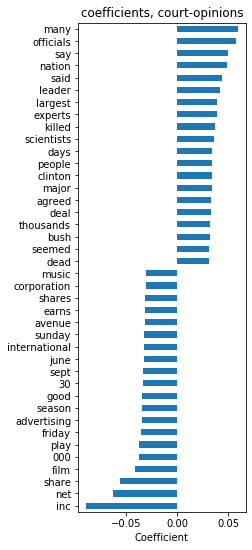

In [140]:
top_k = 20
figsize= (3,9)
cutoff = 300

(coef_df
 .loc[lambda df: df['counts'] > cutoff]['coef']
 .sort_values()
 .pipe(lambda s: pd.concat([s[:top_k], s[-top_k:]]))
 .plot(kind='barh', figsize=figsize, title='coefficients, court-opinions')
)
plt.xlabel('Coefficient')
plt.savefig('figures/2019-09-05__coefficients-court-documents.png', bbox_inches='tight')
plt.savefig('figures/2019-09-05__coefficients-court-documents.pdf', bbox_inches='tight')

In [109]:
coef_df.loc[lambda df: df['counts']==0].shape

(1256, 2)

In [110]:
coef_df.shape

(18937, 2)

In [111]:
court_sorted = pd.concat([
    opinion_df_all.reset_index(),
    pd.Series(lr.predict_proba(court_bow)[:, 1]).to_frame('y_pred'),
], axis=1).sort_values('y_pred', ascending=False)

In [135]:
court_sorted.to_csv("../court_documents/scored_appeals.csv")

In [1]:
import pandas as pd

In [2]:
court_sorted = pd.read_csv("../court_documents/scored_appeals.csv")

In [13]:
print(court_sorted.iloc[7]['plain_text'][:1000])

                                                              September 8, 2015
                                NO. PD-1067-15

                               IN THE
                 COURT OF CRIMINAL APPEALS OF TEXAS


             EX PARTE JAMES RICHARD "RICK" PERRY,
                              Appellant
      ________________________________________________________

               On Appeal from the 390th Judicial District Court,
             Travis County, Texas, Cause No. D-1-DC-14-100139
      ________________________________________________________

  APPELLANT'S CROSS-PETITION FOR DISCRETIONARY REVIEW
    ________________________________________________________


THE BUZBEE LAW FIRM                              BAKER BOTTS L.L.P.
Anthony G. Buzbee                                Thomas R. Phillips
State Bar No. 24001820                           State Bar No. 00000102
JPMorgan Chase Tower                             San Jacinto Center
600 Travis Street, Suite 7300             

In [ ]:
# top examples

# Tiger Oil Corporation (New Tiger)[1] challenges several superior court orders arising from (1) Model Toxics Control Act (MTCA)[2] litigation and a consent decree entered after Washington's Department of Ecology sued New Tiger for gasoline spills in Yakima during the late 1970s and early 1980s, and (2) New Tiger's incomplete remediation efforts under the consent decree...
# Mr. Long was convicted of the shooting death of a fourteen-year-old boy, Ronald Williamson, two weeks after Mr. Williamson threatened Mr. Long at gunpoint...
# In this appeal involving a dispute between law enforcement authorities and the Cayuga Indian Nation concerning the collection of cigarette sales taxes...
# ...a two-count indictment was returned against Governor Perry for violating Sections 36.03(a)(1), 1.07(a)(9)(F) (Count II, coercion of publicservant), and 39.02(a)(2) (Count I, abuse of official capacity) of the Texas Penal Code by threatening to exercise, and then actually exercising, the authority to veto appropriations vested in the Governor by the Texas Constitution. 


# bottom examples

# ...It is also a matter of record that Jones held hostage his infant son in the Dominican Republic for five months to gain financial advantage in the pending divorce that was finalized on July 17, 2013...
# ...filed against the City by current and former police officers, firefighters, and rescue officers (the Officers) alleging that the City breached its contract with them regarding their pay...
# ...in this appeal, Defendant-Appellant Brenda Irene Dickson-Weinberg (Wife or Defendant) challenges (1) the divorce decree entered by the Family Court of the First Circuit (family court)[1] on May 18, 2006 (Divorce Decree), which ended her marriage to Plaintiff-Appellee Jan Michael Weinberg...

# Earlier Explorations with All Data

In [73]:
opinion_df_all = pd.concat(opinion_dfs)
opinion_df_all = opinion_df_all.reset_index(drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


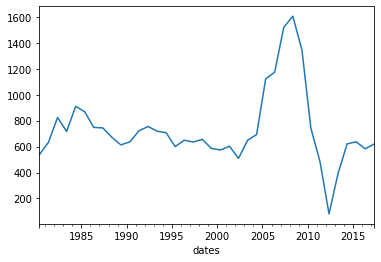

In [92]:
opinion_df_all.assign(c=1).groupby(pd.Grouper(key='dates', freq='365D'))['c'].sum().plot()

In [89]:
opinion_df_all['file'].value_counts()

alactapp       17610
alacivapp       9710
hawapp          7269
arkctapp        5410
bva             3960
scctapp         3861
massappct       3639
oklacivapp      3222
ccpa            2776
asbca           2272
alaskactapp     2188
kyctapp         2125
nmcca           1577
acca            1469
armfor          1218
afcca           1138
eca               97
ndctapp           65
Name: file, dtype: int64

In [ ]:
(opinion_df_all
 .loc[lambda df: df['plain_text'].notnull()]
 .to_csv("../court_documents/unprocessed_appeals_plain_text.csv")
)

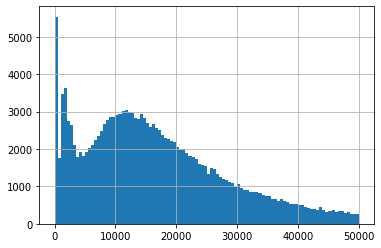

In [64]:
opinion_df_all['plain_text'].str.len().hist(bins=100, range=(0, 50000))

In [73]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
for df in opinion_dfs:
    print('plain_text' in df.columns)
#     if 'plain_text' in df.columns:
#         print(df['plain_text'].isnull().value_counts())

In [85]:
army_cv = CountVectorizer(min_df=.005, max_df=.4)
army_cv.fit_transform(opinion_df_all['plain_text'].dropna())

<166262x10963 sparse matrix of type '<class 'numpy.int64'>'
	with 79582524 stored elements in Compressed Sparse Row format>